# Tutorial 8: Convolution Neural Networks

## Reference
https://cs231n.github.io/convolutional-networks/

## Prerequisites
- Tensorflow
- Keras

## Import Libraries

from keras.layers import Convolution2D, MaxPool2D, Activation
from keras.models import Sequential
import keras.backend as K

K.set_image_data_format('channels_last')

## Visualizing convolution operations

Remember output shape of tensor is dependent on number of kernels.

**STEP 1:** Creating simple convolution model

In [49]:
model = Sequential()
model.add(Convolution2D(1, (3,3), input_shape=(100,100,3)))
model.add(Convolution2D(1, (3,3)))
model.add(MaxPool2D())
model.add(Activation('tanh'))
model.add(Convolution2D(1, (3,3)))
model.add(MaxPool2D())

**STEP 2:** Create a image

In [31]:
from skimage.io import imread
from skimage.transform import resize

I = imread('images/cat.jpeg')
I = resize(I, (100, 100))

In [50]:
import numpy as np
I_conv = model.predict(np.array([I]))

**STEP 3:** Visualizing what goes to next layers

(1, 23, 23, 1)


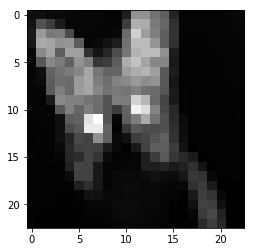

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline

print I_conv.shape
plt.imshow(I_conv[0, :, :, 0], cmap='Greys_r')

## Gradient Ascent

Visualizing what CNN has learned.

In our example, we have not really trained the model therefore output seems just noise image.

### Reference
https://cs231n.github.io/understanding-cnn/

In [56]:
loss = K.mean(model.layers[-1].output[:, :, :, 0])
input_img = model.input

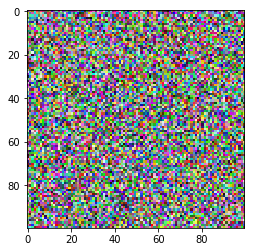

In [66]:
grads = K.gradients(loss, input_img)[0]
iterate = K.function([input_img], [loss, grads])

# we start from a gray image with some noise
input_img_data = np.random.random((1, 100, 100, 3)) * 20 + 128.
# run gradient ascent for 20 steps
for i in range(100):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * 0.1
    
plt.imshow(input_img_data[0])

### Homework

Train a CNN model on MNIST and visualize what it means to maximally activate output in last convolution layer.

## Artistic Style Transfer

### Reference
http://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf

In [103]:
from keras.applications import vgg16
from keras.preprocessing.image import load_img, img_to_array

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg16.preprocess_input(img)
    return img

# util function to convert a tensor into a valid image


def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

width, height = load_img('images/me.png').size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

# get tensor representations of our images
base_image = K.variable(preprocess_image('images/me.png'))
style_reference_image = K.variable(preprocess_image('images/ref.jpg'))

# this will contain our generated image
if K.image_data_format() == 'channels_first':
    combination_image = K.placeholder((1, 3, img_nrows, img_ncols))
else:
    combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

# build the VGG16 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
model = vgg16.VGG16(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')

Model loaded.


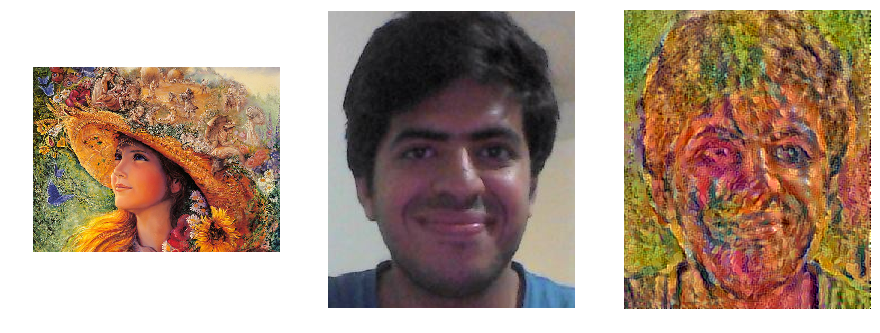

('Start of iteration', 7)
('Current loss value:', 2.8551483e+09)


In [ ]:
content_weight = 0.08
style_weight= 0.7
total_variation_weight = 1.0
iterations= 20
from scipy.optimize import fmin_l_bfgs_b

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

def gram_matrix(x):
    assert K.ndim(x) == 3
    if K.image_data_format() == 'channels_first':
        features = K.batch_flatten(x)
    else:
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

# the "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return K.sum(K.square(combination - base))

# the 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent


def total_variation_loss(x):
    assert K.ndim(x) == 4
    if K.image_data_format() == 'channels_first':
        a = K.square(x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, 1:, :img_ncols - 1])
        b = K.square(x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, :img_nrows - 1, 1:])
    else:
        a = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
        b = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

# combine these loss functions into a single scalar
loss = K.variable(0.)
layer_features = outputs_dict['block4_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(base_image_features,
                                      combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)

# get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)


def eval_loss_and_grads(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_nrows, img_ncols))
    else:
        x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.


class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
if K.image_data_format() == 'channels_first':
    x = np.random.uniform(0, 255, (1, 3, img_nrows, img_ncols)) - 128.
else:
    x = np.random.uniform(0, 255, (1, img_nrows, img_ncols, 3)) - 128.

import pylab as pl
pl.figure(figsize=(15, 10))
from IPython import display
for i in range(iterations):
    print('Start of iteration', i)
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # save current generated image
    img = deprocess_image(x.copy())
    pl.subplot(1, 3, 1)
    pl.imshow(imread('images/ref.jpg'))
    pl.axis('off')
    pl.subplot(1, 3, 2)
    pl.imshow(imread('images/me.png'))
    pl.axis('off')
    pl.subplot(1, 3, 3)
    pl.imshow(img)
    pl.axis('off')
    display.clear_output(wait=True)
    display.display(pl.gcf())
    

display.clear_output(wait=True)